Purpose of this document is to refresh my ML capabilities.

## Load data from INano

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import polars as pl
import polars.selectors as cs

In [21]:
# Load data
time_series = np.genfromtxt("200JSiO2-Coll+200SiO2 1-1_100Hz 2min_GelMA 1vol_no CaCl2_002.txt")

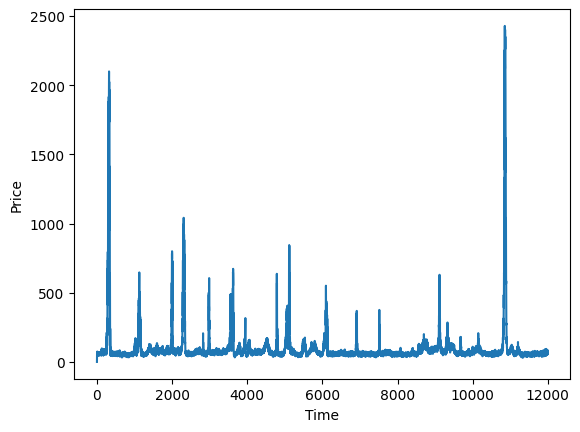

In [24]:
# visualize data
fig, ax = plt.subplots()
ax.plot(time_series)
ax.set(xlabel="Time", ylabel="Price")
plt.show()

In [27]:
zero_and_neg = np.count_nonzero(time_series <= 0)
print(f"Number of <= elements: {zero_and_neg}")

Number of <= elements: 1


I see that the only 0-value is the first point, likely suggesting this is either:
- before they started taking the measurements. I will see if I can treat this point as an outlier and remove it.
- The column name (I later went and checked other datasets, and it is indeed the column name)

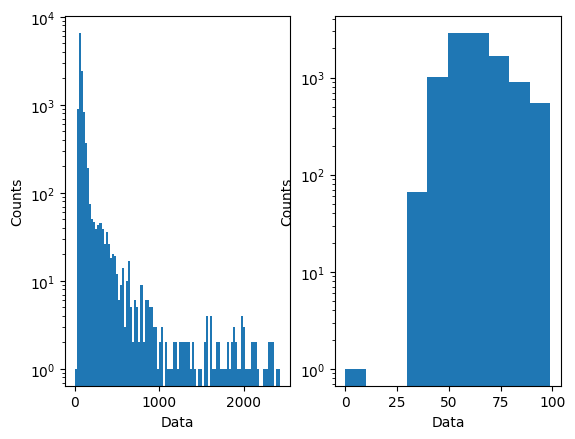

In [34]:
fig, (ax, ax1) = plt.subplots(ncols=2)
ax.hist(time_series, bins=100)
ax.set(xlabel="Data", ylabel="Counts", yscale="log")

ax1.hist([time_series[time_series<100]])
ax1.set(xlabel="Data", ylabel="Counts", yscale="log")

plt.show()

Which it sure does look like

In [35]:
time_series_no0 = time_series[time_series>0]

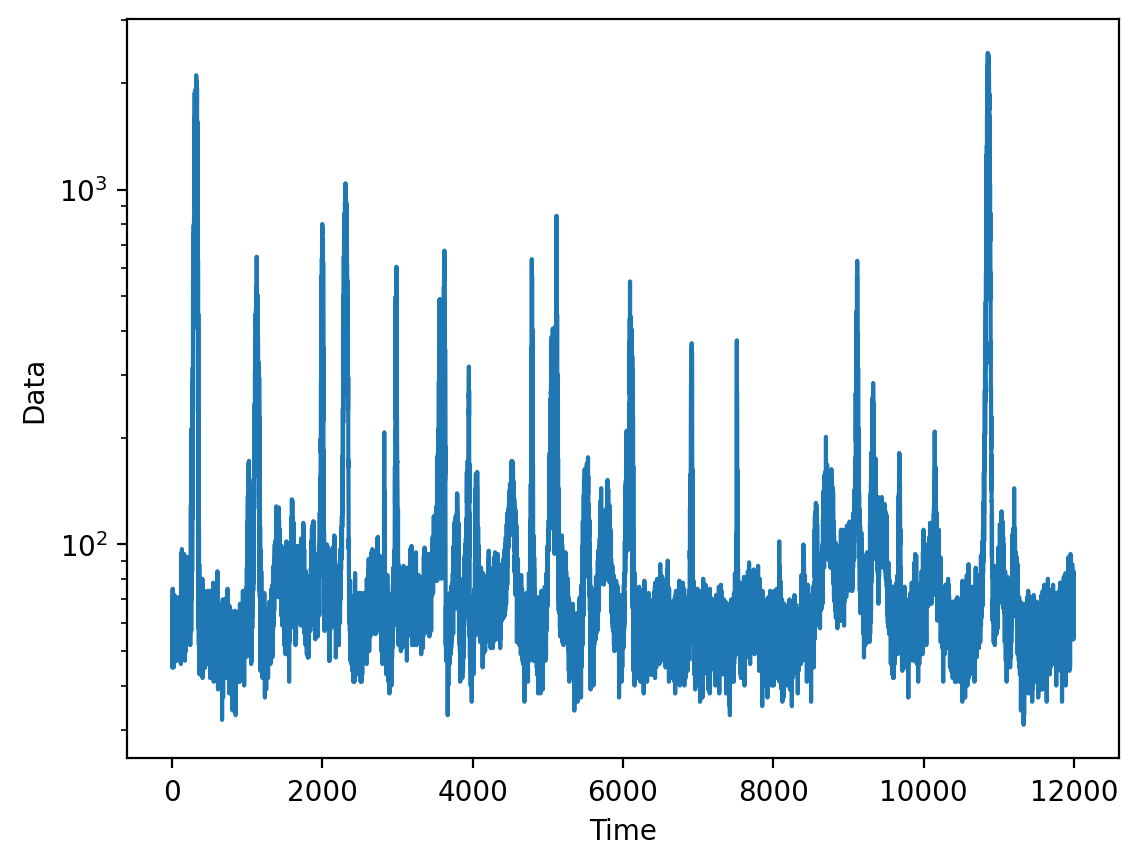

In [41]:
# visualize data
fig, ax = plt.subplots(dpi=200)
ax.plot(time_series_no0)
ax.set(xlabel="Time", ylabel="Data", yscale="log")
plt.show()

In [48]:
# We treat the data as a time series of prices. Take the last 500 points as the future to confirm with
number_of_points = time_series_no0.size
prices = time_series_no0[:number_of_points - 500]
prices_future = time_series_no0[number_of_points - 500 : ]

time = np.arange(prices.size)
time_futures = np.arange(prices.size, number_of_points)

Before we start using more complex models, it would be nice to do simpler models, e.g. regression (OLS, L1, L2)

In [44]:
# Key characteristics
print("Mean", prices.mean(), "Std: ", prices.std())

Mean 100.51052173913044 Std:  167.3508659197066


### Load the data through Polars instead of using Pandas
Disregard everything above

In [2]:
df = pl.read_csv("200JSiO2-Coll+200SiO2 1-1_100Hz 2min_GelMA 1vol_no CaCl2_002.txt")
df = df.rename({"0": "price"})
df.head()

price
i64
52
55
71
57
47


In [3]:
summary = df.select(cs.numeric()).describe()
summary

statistic,price
str,f64
"""count""",12000.0
"""null_count""",0.0
"""mean""",98.87975
"""std""",164.031483
"""min""",31.0
"""25%""",57.0
"""50%""",66.0
"""75%""",84.0
"""max""",2429.0


Feature engineering by introducing lags

In [4]:
lagged_df = df.select(
    "price",
    *[pl.col("price").shift(i).alias(f"lagged_price_{i}h") for i in [1, 2, 3]],  # Lag by 1, 2 and 3 hours
    lagged_price_1d = pl.col("price").shift(24),
    lagged_price_1d_1h = pl.col("price").shift(24 + 1),
    lagged_price_7d = pl.col("price").shift(7*24),
    lagged_price_7d_1h = pl.col("price").shift(7*24+1),
    lagged_mean_24h = pl.col("price").shift(1).rolling_mean(24),
    lagged_max_24h = pl.col("price").shift(1).rolling_max(24),
    lagged_min_24h = pl.col("price").shift(1).rolling_min(24),
    lagged_mean_7d = pl.col("price").shift(1).rolling_mean(7*24),
    lagged_min_7d = pl.col("price").shift(1).rolling_min(7*24),
    lagged_max_7d = pl.col("price").shift(1).rolling_max(7*24),
)

lagged_df.tail(10)

price,lagged_price_1h,lagged_price_2h,lagged_price_3h,lagged_price_1d,lagged_price_1d_1h,lagged_price_7d,lagged_price_7d_1h,lagged_mean_24h,lagged_max_24h,lagged_min_24h,lagged_mean_7d,lagged_min_7d,lagged_max_7d
i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,f64,i64,i64
70,69,67,82,71,79,61,75,68.416667,88,54,65.559524,36,94
71,70,69,67,56,71,63,61,68.375,88,54,65.613095,36,94
66,71,70,69,61,56,76,63,69.0,88,54,65.660714,36,94
54,66,71,70,76,61,71,76,69.208333,88,54,65.60119,36,94
84,54,66,71,87,76,66,71,68.291667,88,54,65.5,36,94
66,84,54,66,63,87,78,66,68.166667,88,54,65.607143,36,94
64,66,84,54,63,63,56,78,68.291667,88,54,65.535714,36,94
78,64,66,84,80,63,67,56,68.333333,88,54,65.583333,36,94
67,78,64,66,68,80,66,67,68.25,88,54,65.64881,36,94


In [5]:
# First values have undefined because of window
lagged_df.head(10)

price,lagged_price_1h,lagged_price_2h,lagged_price_3h,lagged_price_1d,lagged_price_1d_1h,lagged_price_7d,lagged_price_7d_1h,lagged_mean_24h,lagged_max_24h,lagged_min_24h,lagged_mean_7d,lagged_min_7d,lagged_max_7d
i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,f64,i64,i64
52,null,null,null,null,null,null,null,null,null,null,null,null,null
55,52,null,null,null,null,null,null,null,null,null,null,null,null
71,55,52,null,null,null,null,null,null,null,null,null,null,null
57,71,55,52,null,null,null,null,null,null,null,null,null,null
47,57,71,55,null,null,null,null,null,null,null,null,null,null
45,47,57,71,null,null,null,null,null,null,null,null,null,null
57,45,47,57,null,null,null,null,null,null,null,null,null,null
45,57,45,47,null,null,null,null,null,null,null,null,null,null
75,45,57,45,null,null,null,null,null,null,null,null,null,null


In [6]:
# Seperate intro X and y
lagged_df = lagged_df.drop_nulls()  # Remove undefined from lagged features
X = lagged_df.drop("price")
y = lagged_df["price"]
print(f"X shape: {X.shape}\ny shape {y.shape}")

X shape: (11831, 13)
y shape (11831,)


In [7]:
# Split
from sklearn.model_selection import TimeSeriesSplit
ts_cv = TimeSeriesSplit(
    n_splits=3,  # Number of windows
    gap=48,  # data points between train and test, 48 = 2 days
    max_train_size=10_000,
    test_size=3000,
)
all_splits = list(ts_cv.split(X, y))
all_splits

[(array([   0,    1,    2, ..., 2780, 2781, 2782]),
  array([2831, 2832, 2833, ..., 5828, 5829, 5830])),
 (array([   0,    1,    2, ..., 5780, 5781, 5782]),
  array([5831, 5832, 5833, ..., 8828, 8829, 8830])),
 (array([   0,    1,    2, ..., 8780, 8781, 8782]),
  array([ 8831,  8832,  8833, ..., 11828, 11829, 11830]))]

0.13447324400734456


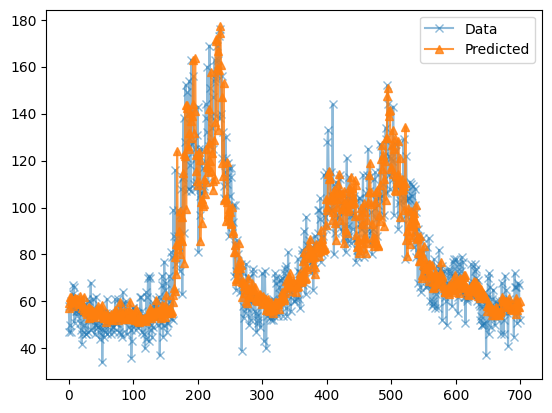

In [26]:
# Illustrate a single train-test example
# Train Gradient Boosting Regressor and evaluate using MAPE (Mean Absolute Percentage Error)
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error

train_idx, test_idx = all_splits[0]  # Only single train-test pair for illustration
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]

model = HistGradientBoostingRegressor().fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_absolute_percentage_error(y_test, y_pred))

points_to_show = 700
hours_to_show = slice(-points_to_show, None)

fig, ax = plt.subplots()
ax.plot(y_test[hours_to_show], "x-", label="Data", alpha=0.5)
ax.plot(y_pred[hours_to_show], "^-", label="Predicted", alpha=0.8)
ax.legend()
plt.show()

Note: This is not as impressive as it first looks. To do this properly, we should do a walk-forward. 

In [9]:
# Do the proper cross validation for all train-test splits
from sklearn.model_selection import cross_val_score
cv_mape_scores = - cross_val_score(
    model, X, y, cv=ts_cv, scoring="neg_mean_absolute_percentage_error"
)

print(cv_mape_scores)
print(f"CV MAPE: {cv_mape_scores.mean():.3f}, +- {cv_mape_scores.std():.3f}")

[0.13447324 0.13076012 0.12748052]
CV MAPE: 0.131, +- 0.003


In [ ]:
from collections import defaultdict

from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_pinball_loss,
    root_mean_squared_error,
)
from sklearn.model_selection import cross_validate


def consolidate_scores(cv_results, scores, metric):
    if metric == "MAPE":
        scores[metric].append(f"{value.mean():.2f} ± {value.std():.2f}")
    else:
        scores[metric].append(f"{value.mean():.1f} ± {value.std():.1f}")

    return scores


scoring = {
    "MAPE": make_scorer(mean_absolute_percentage_error),
    "RMSE": make_scorer(root_mean_squared_error),
    "MAE": make_scorer(mean_absolute_error),
    "pinball_loss_05": make_scorer(mean_pinball_loss, alpha=0.05),
    "pinball_loss_50": make_scorer(mean_pinball_loss, alpha=0.50),
    "pinball_loss_95": make_scorer(mean_pinball_loss, alpha=0.95),
}
loss_functions = ["squared_error", "poisson", "absolute_error"]
scores = defaultdict(list)
for loss_func in loss_functions:
    model = HistGradientBoostingRegressor(loss=loss_func)
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=ts_cv,
        scoring=scoring,
        n_jobs=2,
    )
    time = cv_results["fit_time"]
    scores["loss"].append(loss_func)
    scores["fit_time"].append(f"{time.mean():.2f} ± {time.std():.2f} s")

    for key, value in cv_results.items():
        if key.startswith("test_"):
            metric = key.split("test_")[1]
            scores = consolidate_scores(cv_results, scores, metric)

pinball_loss_95
defaultdict(<class 'list'>, {'loss': ['squared_error', 'poisson', 'absolute_error'], 'fit_time': ['0.25 ± 0.05 s', '0.26 ± 0.05 s', '0.35 ± 0.07 s'], 'MAPE': ['0.13 ± 0.00', '0.13 ± 0.00', '0.13 ± 0.00'], 'RMSE': ['33.4 ± 15.6', '34.8 ± 17.5', '33.2 ± 17.1'], 'MAE': ['13.0 ± 2.6', '13.2 ± 2.7', '12.9 ± 2.6'], 'pinball_loss_05': ['6.3 ± 0.8', '6.1 ± 0.6', '5.9 ± 0.7'], 'pinball_loss_50': ['6.5 ± 1.3', '6.6 ± 1.4', '6.4 ± 1.3'], 'pinball_loss_95': ['6.7 ± 2.2', '7.1 ± 2.3', '6.9 ± 2.2']})


In words: No significant difference between the loss methods

### Quantile regression

In [14]:
quantile_list = [0.05, 0.5, 0.95]

for quantile in quantile_list:
    model = HistGradientBoostingRegressor(loss="quantile", quantile=quantile)
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=ts_cv,
        scoring=scoring,
        n_jobs=2,
    )
    time = cv_results["fit_time"]
    scores["fit_time"].append(f"{time.mean():.2f} ± {time.std():.2f} s")

    scores["loss"].append(f"quantile {int(quantile * 100)}")
    for key, value in cv_results.items():
        if key.startswith("test_"):
            metric = key.split("test_")[1]
            scores = consolidate_scores(cv_results, scores, metric)

scores_df = pl.DataFrame(scores)#.set_index("loss")
scores_df   


loss,fit_time,MAPE,RMSE,MAE,pinball_loss_05,pinball_loss_50,pinball_loss_95
str,str,str,str,str,str,str,str
"""squared_error""","""0.25 ± 0.05 s""","""0.13 ± 0.00""","""33.4 ± 15.6""","""13.0 ± 2.6""","""6.3 ± 0.8""","""6.5 ± 1.3""","""6.7 ± 2.2"""
"""poisson""","""0.26 ± 0.05 s""","""0.13 ± 0.00""","""34.8 ± 17.5""","""13.2 ± 2.7""","""6.1 ± 0.6""","""6.6 ± 1.4""","""7.1 ± 2.3"""
"""absolute_error""","""0.35 ± 0.07 s""","""0.13 ± 0.00""","""33.2 ± 17.1""","""12.9 ± 2.6""","""5.9 ± 0.7""","""6.4 ± 1.3""","""6.9 ± 2.2"""
"""quantile 5""","""0.44 ± 0.08 s""","""0.20 ± 0.01""","""74.0 ± 60.9""","""24.5 ± 9.1""","""1.7 ± 0.3""","""12.3 ± 4.6""","""22.8 ± 8.8"""
"""quantile 50""","""0.42 ± 0.04 s""","""0.13 ± 0.00""","""33.2 ± 17.1""","""12.9 ± 2.6""","""5.9 ± 0.7""","""6.4 ± 1.3""","""6.9 ± 2.2"""
"""quantile 95""","""0.35 ± 0.02 s""","""0.29 ± 0.01""","""47.2 ± 11.0""","""25.1 ± 3.9""","""22.2 ± 3.6""","""12.6 ± 1.9""","""2.9 ± 1.4"""


In [15]:
# Find losses that minimise each metric
def min_arg(col):
    col_split = pl.col(col).str.split(" ")
    return pl.arg_sort_by(
        col_split.list.get(0).cast(pl.Float64),
        col_split.list.get(2).cast(pl.Float64)
    ).first()
    
scores_df.select(
    pl.col("loss").get(min_arg(col_name)).alias(col_name)
    for col_name in scores_df.columns
    if col_name != "loss"
)

fit_time,MAPE,RMSE,MAE,pinball_loss_05,pinball_loss_50,pinball_loss_95
str,str,str,str,str,str,str
"""squared_error""","""squared_error""","""absolute_error""","""absolute_error""","""quantile 5""","""absolute_error""","""quantile 95"""


In [17]:
# Visualize predictions
all_splits = list(ts_cv.split(X, y))
train_idx, test_idx = all_splits[0]

X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]

max_iter = 50
gbrt_mean_poisson = HistGradientBoostingRegressor(loss="poisson", max_iter=max_iter)
gbrt_mean_poisson.fit(X_train, y_train)
mean_predictions = gbrt_mean_poisson.predict(X_test)

gbrt_median = HistGradientBoostingRegressor(loss="quantile", quantile=0.5, max_iter=max_iter)
gbrt_median.fit(X_train, y_train)
median_prediction = gbrt_median.predict(X_test)

gbrt_pecentile_5 = HistGradientBoostingRegressor(loss="quantile", quantile=0.05, max_iter=max_iter)
gbrt_pecentile_5.fit(X_train, y_train)
pecentile_5_prediction = gbrt_pecentile_5.predict(X_test)

gbrt_pecentile_95 = HistGradientBoostingRegressor(loss="quantile", quantile=0.95, max_iter=max_iter)
gbrt_pecentile_95.fit(X_train, y_train)
pecentile_95_prediction = gbrt_pecentile_95.predict(X_test)


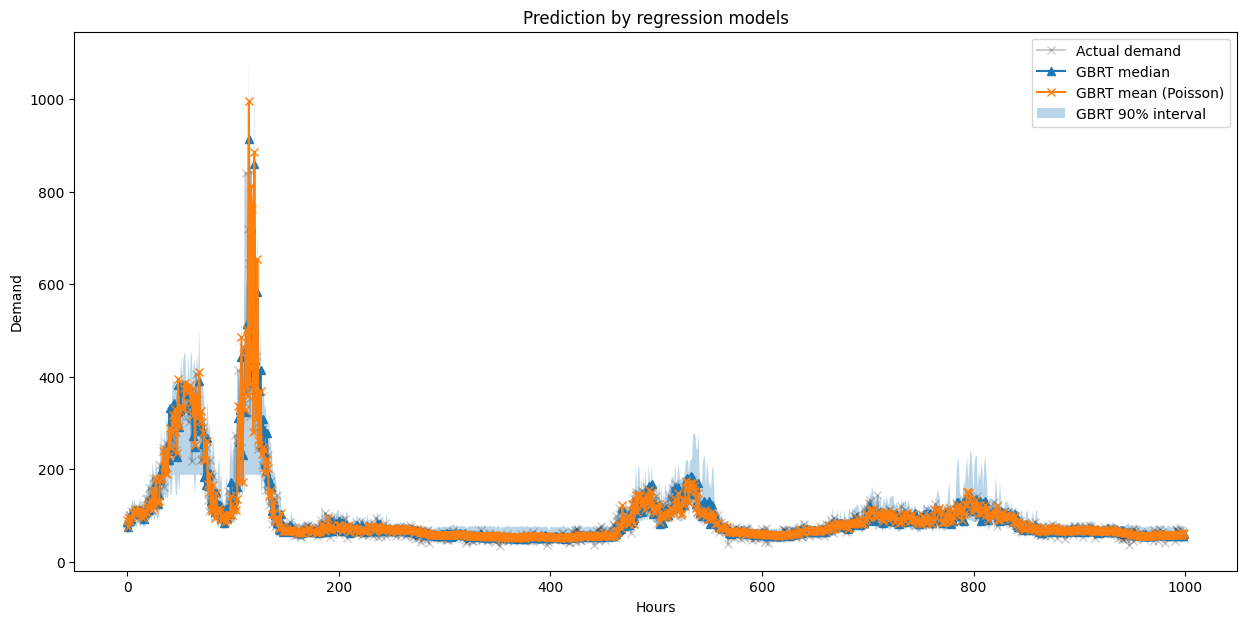

In [28]:
n_hours = 1000
last_hours = slice(-n_hours, None)
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(y_test[last_hours], "x-", alpha=0.2, label="Actual demand", c="black")
ax.plot(median_prediction[last_hours], "^-", label="GBRT median")
ax.plot(mean_predictions[last_hours], "x-", label="GBRT mean (Poisson)")
ax.fill_between(
    np.arange(n_hours),
    pecentile_5_prediction[last_hours],
    pecentile_95_prediction[last_hours],
    alpha=0.3,
    label="GBRT 90% interval",
)
ax.legend()
ax.set(title="Prediction by regression models", xlabel="Hours", ylabel="Demand")
plt.show()

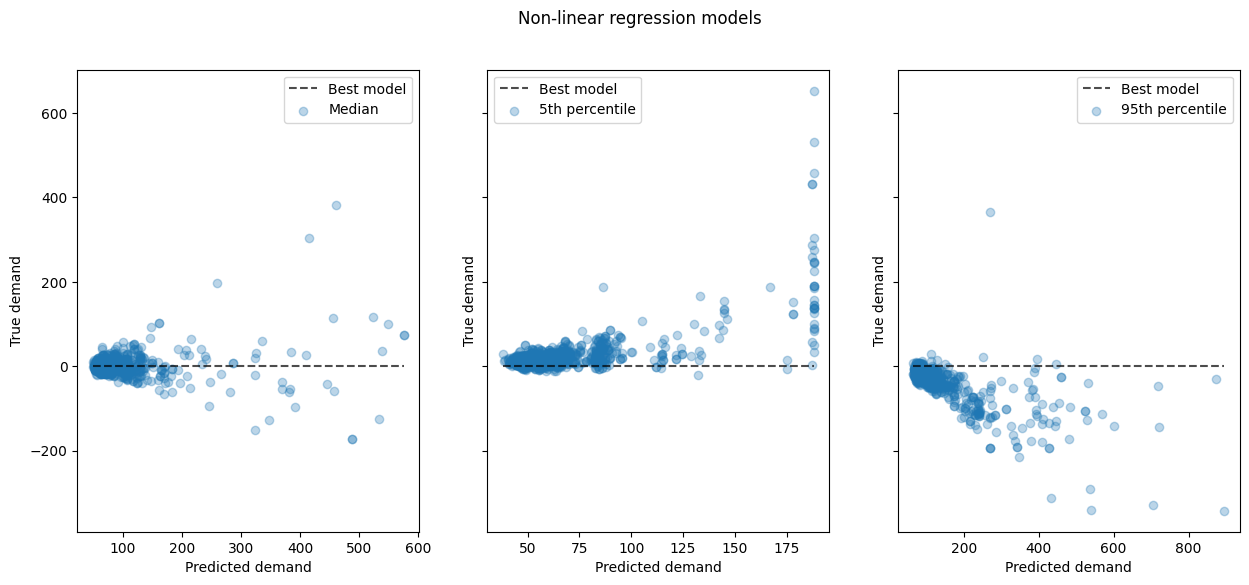

In [21]:
from sklearn.metrics import PredictionErrorDisplay

fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    median_prediction,
    pecentile_5_prediction,
    pecentile_95_prediction,
]
labels = [
    "Median",
    "5th percentile",
    "95th percentile",
]
for ax, pred, label in zip(axes, predictions, labels):
    PredictionErrorDisplay.from_predictions(
        y_true=y_test,
        y_pred=pred,
        kind="residual_vs_predicted",
        scatter_kwargs={"alpha": 0.3},
        ax=ax,
    )
    ax.set(xlabel="Predicted demand", ylabel="True demand")
    ax.legend(["Best model", label])

plt.show()

## Walk forward backtesting

In [34]:
model = HistGradientBoostingRegressor(loss="absolute_error")

y_true_all = []
y_pred_all = []
test_idx_all = []

for train_idx, test_idx in ts_cv.split(X, y):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    y_true_all.append(y_test)
    y_pred_all.append(y_pred)
    test_idx_all.append(test_idx)

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)
test_idx_all = np.concatenate(test_idx_all)

print("Walk-forward MAE:  ", mean_absolute_error(y_true_all, y_pred_all))
print("Walk-forward RMSE: ", root_mean_squared_error(y_true_all, y_pred_all))
print("Walk-forward MAPE: ", mean_absolute_percentage_error(y_true_all, y_pred_all))

Walk-forward MAE:   12.890232437816355
Walk-forward RMSE:  37.351113786610135
Walk-forward MAPE:  0.13029985115746465
